-------------------

## Basic Tutorial for `pysal.spaghetti`

In [1]:
import os
last_modified = None
if os.name == "posix":
    last_modified = !stat -f\
                    "# This notebook was last updated: %Sm"\
                     Network_Usage.ipynb
elif os.name == "nt":
    last_modified = !for %a in (Network_Usage.ipynb)\
                    do echo # This notebook was last updated: %~ta
    
if last_modified:
    get_ipython().set_next_input(last_modified[-1])

In [ ]:
# This notebook was last updated: Nov 24 15:23:24 2018

--------------------------

In [4]:
# pysal submodule imports
from libpysal import examples
import spaghetti as spgh
import esda

import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

__author__ = "James Gaboardi <jgaboardi@gmail.com>"

### Instantiate a network

In [5]:
ntw = spgh.Network(in_data=examples.get_path('streets.shp'))

### Snap point patterns to the network

In [6]:
# Crimes
ntw.snapobservations(examples.get_path('crimes.shp'), 'crimes', attribute=True)
# Schools
ntw.snapobservations(examples.get_path('schools.shp'), 'schools', attribute=False)

### A network is composed of a single topological representation of a road and $n$ point patterns which are snapped to the network.

In [7]:
ntw.pointpatterns

{'crimes': <spaghetti.network.PointPattern at 0x1a20c3a668>,
 'schools': <spaghetti.network.PointPattern at 0x1a20c3a5f8>}

### Attributes for every point pattern

1. `dist_to_node` dict keyed by pointid with the value being a dict in the form 
        {node: distance to node, node: distance to node}
2. `obs_to_edge` dict keyed by edge with the value being a dict in the form 
        {pointID:(x-coord, y-coord), pointID:(x-coord, y-coord), ... }
3. `obs_to_node`
4. `points` geojson like representation of the point pattern.  Includes properties if read with attributes=True
5. `snapped_coordinates` dict keyed by pointid with the value being (x-coord, y-coord)

### Counts per edge are important, but should not be precomputed since we have different representations of the network (digitized and graph currently).  (Relatively) Uniform segmentation still needs to be done.

In [8]:
counts = ntw.count_per_edge(ntw.pointpatterns['crimes'].obs_to_edge,
                            graph=False)

In [9]:
sum(list(counts.values())) / float(len(counts.keys()))

2.682242990654206

### Segmentation

In [10]:
n200 = ntw.segment_edges(200.0)

In [11]:
counts = n200.count_per_edge(n200.pointpatterns['crimes'].obs_to_edge, graph=False)
sum(counts.values()) / float(len(counts.keys()))

2.05

### Create `geopandas.GeoDataFrame` objects of the nodes and edges

In [12]:
# 'full' unsegmented network
nodes_df, edges_df = spgh.element_as_gdf(ntw, nodes=ntw.node_coords,
                                         edges=ntw.edges)
# network segmented at 200-meter increments
nodes200_df, edges200_df = spgh.element_as_gdf(ntw, nodes=n200.node_coords,
                                               edges=n200.edges)

### Visualization of the shapefile derived, unsegmented network with nodes in a larger, blue, semi-opaque form and the distance segmented network with small, red, fully opaque nodes.

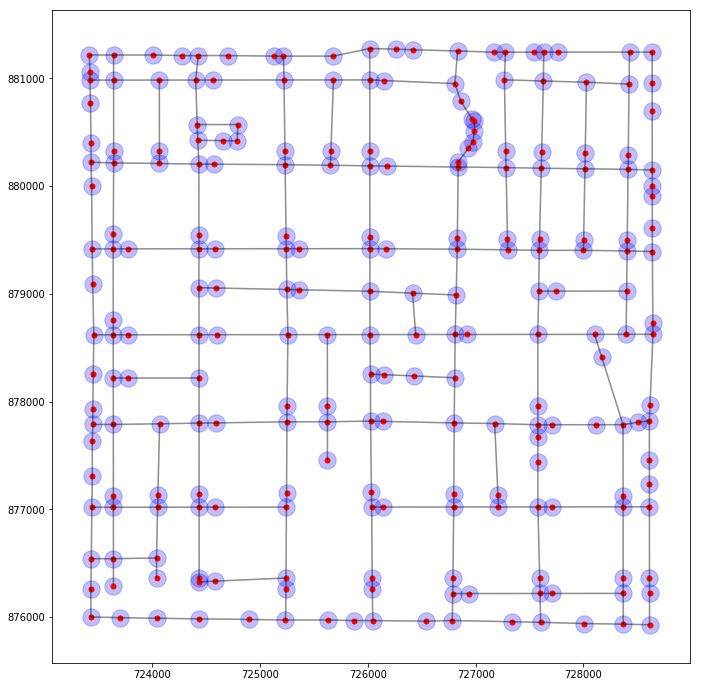

In [13]:
base = edges_df.plot(color='k', alpha=.25, figsize=(12,12))
nodes_df.plot(ax=base, color='b', markersize=300, alpha=.25)
edges200_df.plot(ax=base, color='k', alpha=.25)
nodes200_df.plot(ax=base, color='r', markersize=25, alpha=1.)

### Moran's I using the digitized network

In [14]:
# Binary Adjacency
w = ntw.contiguityweights(graph=False)

# Build the y vector
edges = w.neighbors.keys()
y = np.zeros(len(edges))
for i, e in enumerate(edges):
    if e in counts.keys():
        y[i] = counts[e]

# Moran's I
res = esda.moran.Moran(y, w, permutations=99)
print(dir(res))

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_statistic', 'by_col', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


### Moran's I using the graph representation to generate the W

* Note that we have to regenerate the counts per edge, since the graph will have less edges.

In [15]:
counts = ntw.count_per_edge(ntw.pointpatterns['crimes'].obs_to_edge, graph=True)

# Binary Adjacency
w = ntw.contiguityweights(graph=True)

# Build the y vector
edges = w.neighbors.keys()
y = np.zeros(len(edges))
for i, e in enumerate(edges):
    if e in counts.keys():
        y[i] = counts[e]

# Moran's I
res = esda.moran.Moran(y, w, permutations=99)

print(dir(res))

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_statistic', 'by_col', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


### Moran's I using the segmented network and intensities instead of counts

In [16]:
# Binary Adjacency
w = n200.contiguityweights(graph=False)

# Compute the counts
counts = n200.count_per_edge(n200.pointpatterns['crimes'].obs_to_edge, graph=False)

# Build the y vector and convert from raw counts to intensities
edges = w.neighbors.keys()
y = np.zeros(len(edges))
for i, e in enumerate(edges):
    if e in counts.keys():
        length = n200.edge_lengths[e]
        y[i] = counts[e] / length

# Moran's I
res = esda.moran.Moran(y, w, permutations=99)

print(dir(res))

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_statistic', 'by_col', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


### Timings for distance based methods, e.g. G-function

In [17]:
t1 = time.time()
n0 = ntw.allneighbordistances(ntw.pointpatterns['crimes'])
print(time.time()-t1)

0.4652080535888672


In [18]:
t1 = time.time()
n1 = n200.allneighbordistances(n200.pointpatterns['crimes'])
print(time.time()-t1)

2.18487286567688


* Note that the first time these methods are called, the underlying node-to-node shortest path distance matrix has to be calculated. Subsequent calls will not require this, and will be much faster:

In [19]:
t1 = time.time()
n0 = ntw.allneighbordistances(ntw.pointpatterns['crimes'])
print(time.time()-t1)

0.1767730712890625


In [20]:
t1 = time.time()
n1 = n200.allneighbordistances(n200.pointpatterns['crimes'])
print(time.time()-t1)

0.17598915100097656


### Simulate a point pattern on the network

* Need to supply a count of the number of points and a distirbution (default is uniform).  Generally, this will not be called by the user, since the simulation will be used for Monte Carlo permutation.

In [21]:
npts = ntw.pointpatterns['crimes'].npoints
sim = ntw.simulate_observations(npts)
sim

### F-function

In [22]:
fres = spgh.NetworkF(ntw, ntw.pointpatterns['crimes'],
                     permutations=99)

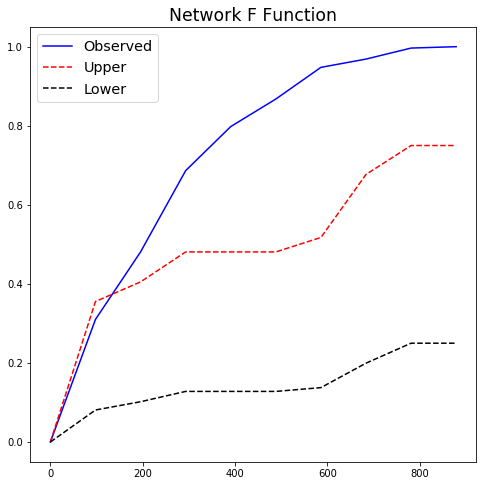

In [23]:
plt.figure(figsize=(8,8))
plt.plot(fres.xaxis, fres.observed, 'b-', linewidth=1.5, label='Observed')
plt.plot(fres.xaxis, fres.upperenvelope, 'r--', label='Upper')
plt.plot(fres.xaxis, fres.lowerenvelope, 'k--', label='Lower')
plt.legend(loc='best', fontsize='x-large')
plt.title('Network F Function', fontsize='xx-large')
plt.show()

### Create a nearest neighbor matrix using the crimes point pattern

* Right now, both the G and K functions generate a full distance matrix.  This is because, I know that the full generation is correct and I believe that the truncated generated, e.g. nearest neighbor, has a bug.

### G-function

In [24]:
gres = spgh.NetworkG(ntw, ntw.pointpatterns['crimes'],
                     permutations=99)

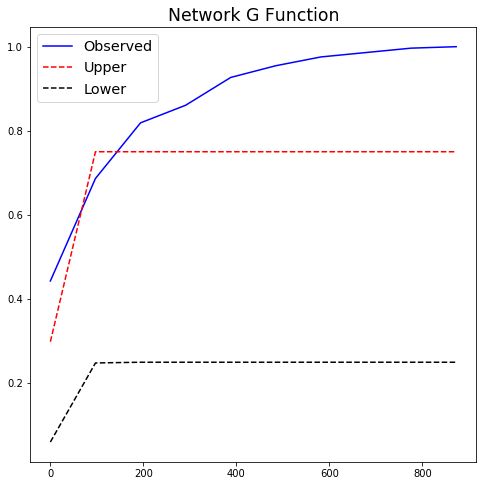

In [25]:
plt.figure(figsize=(8,8))
plt.plot(gres.xaxis, gres.observed, 'b-', linewidth=1.5, label='Observed')
plt.plot(gres.xaxis, gres.upperenvelope, 'r--', label='Upper')
plt.plot(gres.xaxis, gres.lowerenvelope, 'k--', label='Lower')
plt.legend(loc='best', fontsize='x-large')
plt.title('Network G Function', fontsize='xx-large')
plt.show()

### K-function

In [26]:
kres = spgh.NetworkK(ntw, ntw.pointpatterns['crimes'],
                     permutations=99)

/Users/jgaboardi/spaghetti/spaghetti/analysis.py:308: RuntimeWarning: invalid value encountered in less_equal
  y[i] = len(nearest[nearest <= s])


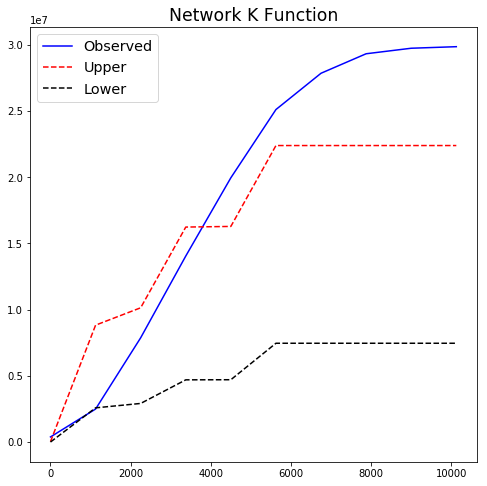

In [27]:
plt.figure(figsize=(8,8))
plt.plot(kres.xaxis, kres.observed, 'b-', linewidth=1.5, label='Observed')
plt.plot(kres.xaxis, kres.upperenvelope, 'r--', label='Upper')
plt.plot(kres.xaxis, kres.lowerenvelope, 'k--', label='Lower')
plt.legend(loc='best', fontsize='x-large')
plt.title('Network K Function', fontsize='xx-large')
plt.show()

-----------